# Linear Regression
### EK 10/26

Using all features to predict attention with linear regression.

### Imports

In [204]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler


### Read in data

In [205]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# drop when attention is 0
games = games[games['attention'] > 0]
# adjust attention
# take log of attention
games['log_attention'] = np.log10(games['attention'])


In [206]:
games

,date,game_id,season,week,weekday,gametime,home_team,away_team,home_win_pct,away_win_pct,num_lead_changes,total_score,score_differential,overtime,attention,log_attention
0,9/5/13,2013_01_BAL_DEN,2013,1,Thursday,20:30,DEN,BAL,0.000000,0.000000,1,76,22,0,5800,3.763428
1,9/8/13,2013_01_NE_BUF,2013,1,Sunday,13:00,BUF,NE,0.000000,0.000000,2,44,2,0,592,2.772322
2,9/8/13,2013_01_SEA_CAR,2013,1,Sunday,13:00,CAR,SEA,0.000000,0.000000,2,19,5,0,265,2.423246
3,9/8/13,2013_01_CIN_CHI,2013,1,Sunday,13:00,CHI,CIN,0.000000,0.000000,2,45,3,0,316,2.499687
4,9/8/13,2013_01_MIA_CLE,2013,1,Sunday,13:00,CLE,MIA,0.000000,0.000000,2,33,13,0,429,2.632457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,12/31/17,2017_17_OAK_LAC,2017,17,Sunday,16:25,LAC,OAK,0.533333,0.400000,2,40,20,0,1464,3.165541
1276,12/31/17,2017_17_BUF_MIA,2017,17,Sunday,16:25,MIA,BUF,0.400000,0.533333,0,38,6,0,1308,3.116608
1277,12/31/17,2017_17_ARI_SEA,2017,17,Sunday,16:25,SEA,ARI,0.600000,0.466667,2,50,2,0,192,2.283301
1278,12/31/17,2017_17_NO_TB,2017,17,Sunday,16:25,TB,NO,0.266667,0.733333,4,55,7,0,1619,3.209247


### Adjust game time to minutes and date to datetime format

In [207]:
games['gametime'] = games['gametime'].str.replace(':', '').astype(int)
games['date'] = pd.to_datetime(games['date'])

### Encode categorical features

In [208]:
categorical_cols = ['weekday', 'home_team', 'away_team']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)


### Visualize numeric features

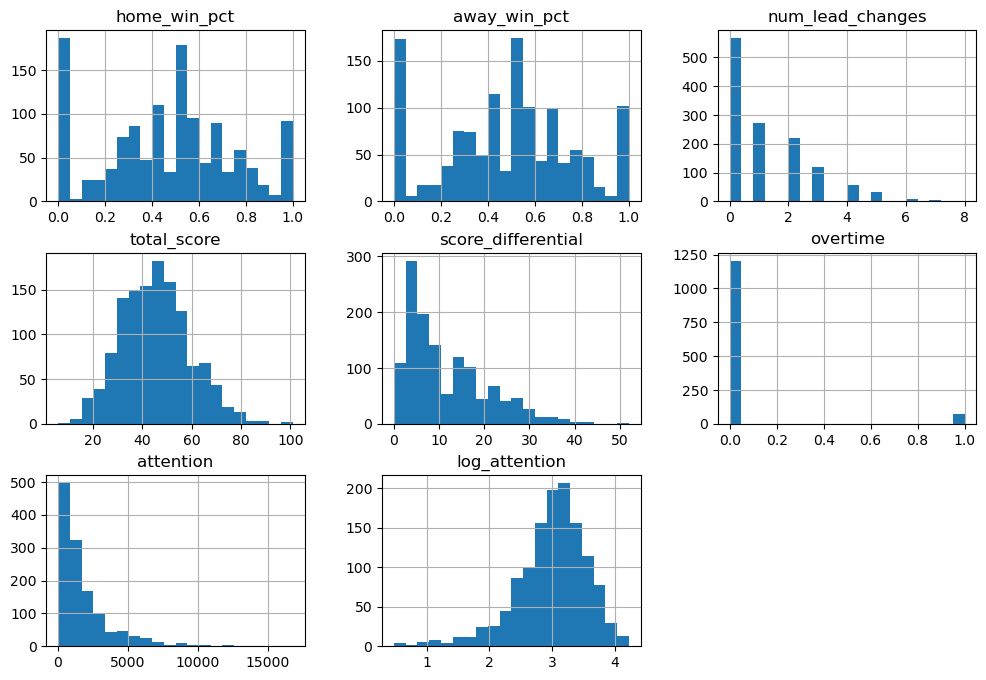

In [209]:

numeric_cols = ['home_win_pct','away_win_pct','num_lead_changes','total_score','score_differential','overtime','attention', 'log_attention']
games[numeric_cols].hist(figsize=(12,8), bins=20)
plt.show()

- Attention is right skewed, so I took the log of it and it looks more normal
- Score differential and # of lead changes are also right skewed

### Correlation Analysis

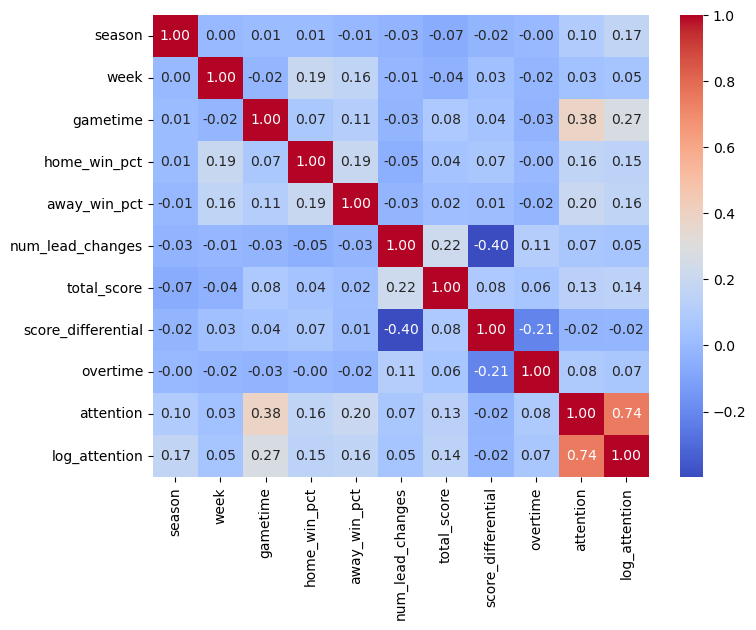

In [210]:
plt.figure(figsize=(8,6))
sns.heatmap(games_encoded.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


- Highest correlation (-0.40) between number of lead changes and score differential and attention and log attention (expected)

### Attention by Weekday

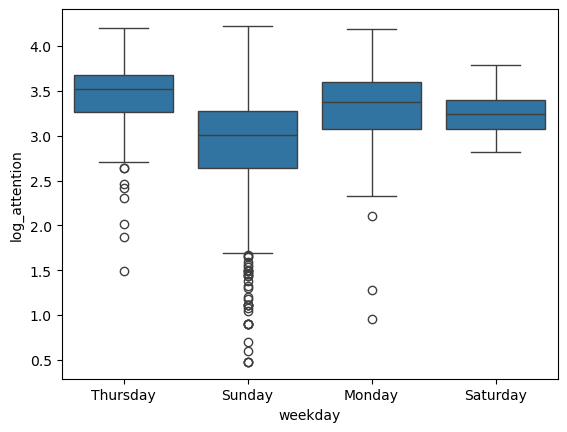

In [211]:
sns.boxplot(x='weekday', y='log_attention', data=games)
plt.show()


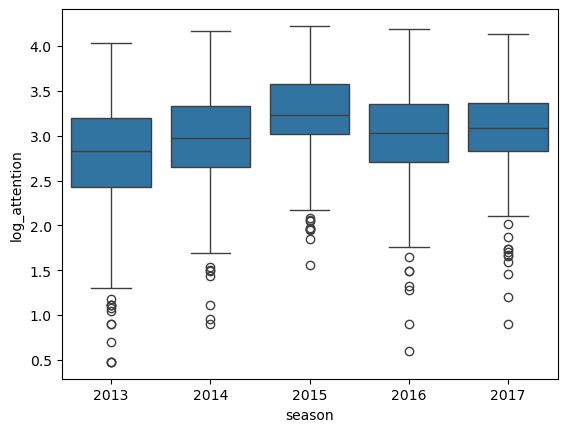

In [212]:
sns.boxplot(x='season', y='log_attention', data=games)
plt.show()

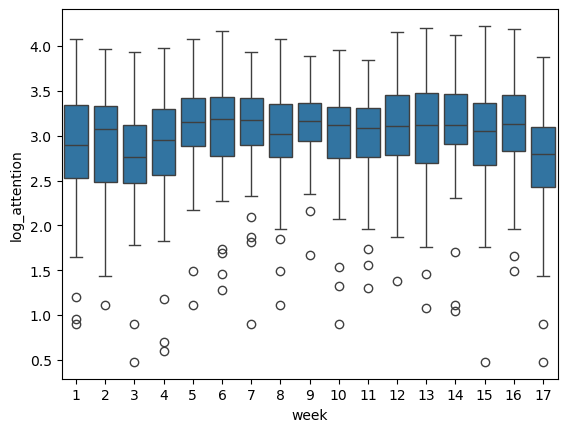

In [213]:
sns.boxplot(x='week', y='log_attention', data=games)
plt.show()

### Check for multicollinearity

In [214]:
X = games_encoded.select_dtypes(include='number').drop(columns=['attention', 'log_attention'])
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF', ascending=False)


,feature,VIF
0,season,43.232018
2,gametime,29.464110
6,total_score,12.895568
1,week,4.551444
4,away_win_pct,4.109396
3,home_win_pct,3.951568
7,score_differential,3.374207
5,num_lead_changes,2.196419
8,overtime,1.121154


- Need to think about multicollinearity with season, gametime, and total_score.

## Linear Regression

In [215]:
# Drop irrelevant columns
X = games_encoded.drop(columns=['attention','log_attention', 'game_id', 'date'])  # only numeric/coded features
y = games_encoded['log_attention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.37830975219484214
R^2: 0.6276775552632853


In [216]:


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaled linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance After Scaling:")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

importance = np.abs(lr.coef_)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_,
    'Absolute Importance': importance
}).sort_values(by='Absolute Importance', ascending=False)

print("Top Features by Importance (after scaling):")
print(feature_importance.tail(20))


Model Performance After Scaling:
RMSE: 0.3783
R^2: 0.6277
Top Features by Importance (after scaling):
               Feature  Coefficient  Absolute Importance
58       away_team_JAX     0.188575             0.188575
76       away_team_TEN     0.187188             0.187188
67       away_team_NYJ     0.186704             0.186704
74       away_team_STL     0.180615             0.180615
27        home_team_LA     0.138487             0.138487
60        away_team_LA     0.106063             0.106063
0               season     0.104435             0.104435
61       away_team_LAC     0.097786             0.097786
28       home_team_LAC     0.090781             0.090781
2             gametime     0.076778             0.076778
4         away_win_pct     0.064230             0.064230
6          total_score     0.054412             0.054412
10      weekday_Sunday    -0.047252             0.047252
11    weekday_Thursday     0.044989             0.044989
8             overtime     0.037967        

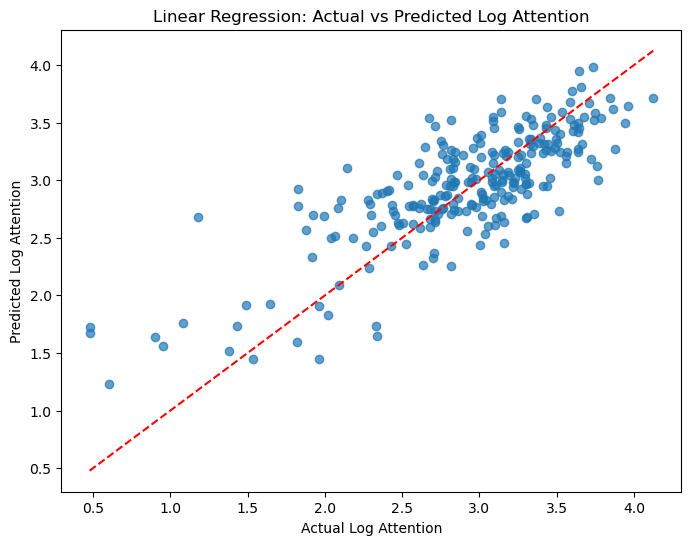

In [217]:
# plot linear regression model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Log Attention")
plt.ylabel("Predicted Log Attention")
plt.title("Linear Regression: Actual vs Predicted Log Attention")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [218]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coefficients.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
19,home_team_DAL,0.330812
22,home_team_GB,0.320898
31,home_team_NE,0.312507
55,away_team_GB,0.302886
39,home_team_SEA,0.296575
...,...,...
1,week,0.022305
5,num_lead_changes,0.012184
9,weekday_Saturday,-0.008350
7,score_differential,-0.009637


- More popular teams with higher coefficients... makes sense (I think?)

### Residual analysis

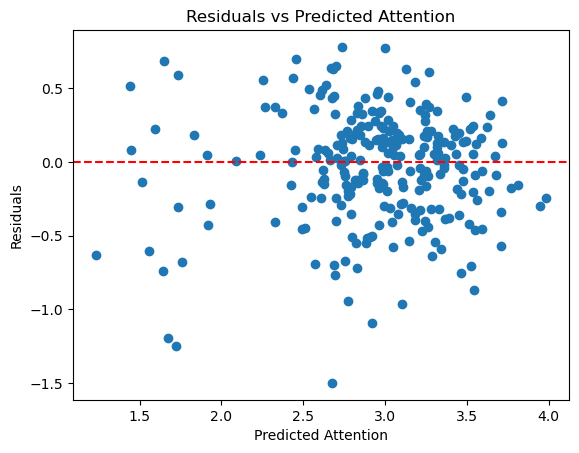

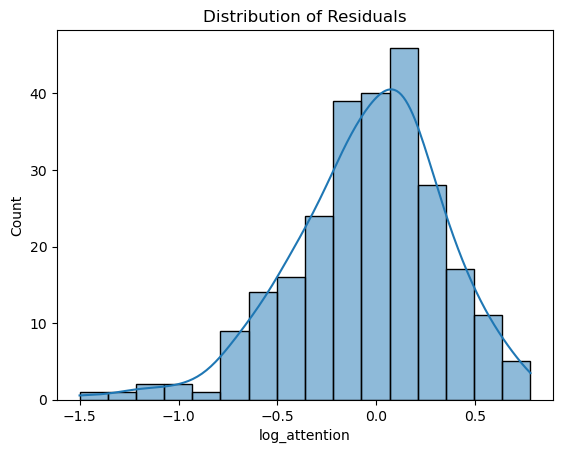

In [219]:
# Residual analysis 
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Attention")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Attention")
plt.show()
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()


### LR with Interaction Terms

In [220]:
# interaction terms
X['home_away_win_interaction'] = X['home_win_pct'] * X['away_win_pct']
X['lead_diff_interaction'] = X['num_lead_changes'] * X['score_differential']
X['total_score_leads_interaction'] = X['total_score'] * X['num_lead_changes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("With Selective Interaction Terms:")
print("RMSE:", rmse)
print("R^2:", r2)


With Selective Interaction Terms:
RMSE: 0.37756113537844915
R^2: 0.6291496350225692


In [221]:
# Linear regression for home team == NE or visiting team == NE
games_dal = games[(games['home_team'] == 'NE') | (games['away_team'] == 'NE')]
games_dal = pd.get_dummies(games_dal, columns=categorical_cols, drop_first=True)
X_dal = games_dal.select_dtypes(include='number').drop(columns=['attention', 'log_attention'])
y_dal = games_dal['log_attention']
X_train_dal, X_test_dal, y_train_dal, y_test_dal = train_test_split(X_dal, y_dal, test_size=0.2, random_state=42)
lr_dal = LinearRegression()
lr_dal.fit(X_train_dal, y_train_dal)
y_pred_dal = lr_dal.predict(X_test_dal)
rmse_dal = np.sqrt(mean_squared_error(y_test_dal, y_pred_dal))
r2_dal = r2_score(y_test_dal, y_pred_dal)
print("NE Specific Model:")
print("RMSE:", rmse_dal)
print("R^2:", r2_dal)


NE Specific Model:
RMSE: 0.30700111973663713
R^2: 0.482471630032994
